In [1]:
#Import Necessary Libraries
from confluent_kafka import Producer, Consumer, KafkaError
import pandas as pd
import json
from faker import Faker
import matplotlib.pyplot as plt


In [2]:
# Create Faker instance for generating fake data and localise to US just incase of Data Protection issues
fake = Faker('en_US')
#Define the topic variable
topic = 'mobile_data'

#Producer settings dictionary
producer_config = {
    'bootstrap.servers': 'pkc-lzvrd.us-west4.gcp.confluent.cloud:9092',
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': 'RGLOI7DV63C35R2X',
    'sasl.password': 'SZ3VUVgAf2AGKRq9SIXGe6Glbuc7JWglUKu/zzzJvBHoVfVMpvp0KJmDUJeKMvQH',  
}
#Consumer settings dictionary
consumer_config ={
    'bootstrap.servers': 'pkc-lzvrd.us-west4.gcp.confluent.cloud:9092',
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': 'RGLOI7DV63C35R2X',
    'sasl.password': 'SZ3VUVgAf2AGKRq9SIXGe6Glbuc7JWglUKu/zzzJvBHoVfVMpvp0KJmDUJeKMvQH',
    'group.id': 'cluster_0',
    'auto.offset.reset': 'earliest',
    
}

In [3]:
#Create a function for function for Producing Data into a Kafka Cluster

def Produce():
    # Define number of messages to generate
    num_messages = 100

    # Use fake Library to generate synthetic data and send to Kafka topic
    producer = Producer(producer_config)


    #Create Synthetic data to be ingested into Kafka Cluster
    for i in range(num_messages):
        data = {
            'sender_phone_number':fake.phone_number(),
            'receiver_phone_number': fake.phone_number(),
            'transaction_amount': fake.random_int(),
            'transaction_time': fake.time(),
            'transaction_date':fake.date()
        }
        
        # Serialize data to JSON and send to Kafka topic
        producer.produce(topic, key=str(i), value=json.dumps(data))
        producer.flush()


In [4]:
#Create a function for Extracting Data from Kafka Cluster

def Extract():
    #Create a consumer object
    consumer = Consumer(consumer_config)

    # Subscribe to the Kafka topic
    consumer.subscribe([topic])

    # Define an empty list to store the JSON data
    json_data_list = []

    # Consume data from Kafka
    #Define max messages and message count variables so as to create a condition to exit the While loop
    max_messages = 100
    message_count = 0

    while True:
        msg = consumer.poll(timeout=1.0)
        if msg is None:
            continue
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                print('Reached end of partition')
            else:
                print('Error while consuming message: {}'.format(msg.error()))
        else:
            # Convert the message value from bytes to string
            json_string = msg.value().decode('utf-8')
            
            # Parse the JSON data
            json_data = json.loads(json_string)
            
            # Append the JSON data to the list
            json_data_list.append(json_data)
            
        
            #Increment the message counter
            message_count += 1

            # Exit the loop when we have consumed the maximum number of messages set in max_messages variable
            if message_count >= max_messages:
                break
            
    # Load the JSON data into a Pandas DataFrame
    df = pd.DataFrame(json_data_list)
    #Close the Kafka consumer
    consumer.close()
    return df

In [5]:
#Create transform function to transform data to determine the year that had the highest amount of transactions
def Transform(df):
    #Drop null values
    df.dropna(inplace = True)
    #Change the Transaction date column to date time
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    #Group the data by transaction year
    grouped_df = df.groupby(df['transaction_date'].dt.year).sum().reset_index()
    #Sort by transaction amounts in descending Order
    grouped_df= grouped_df.sort_values('transaction_amount', ascending= False)
    print(grouped_df.head())
    return grouped_df

In [6]:
#Create a function to plot the grouped df
def Visualize(grouped_df):
    plt.bar(x=grouped_df['transaction_date'],height = grouped_df['transaction_amount'])
    plt.xlabel('Year')
    plt.ylabel('Amount')
    plt.title('Yearly Transactions',loc = 'left')
    #Pick the location of first record and create an annotation
    text1 = f'Highest Transaction year {grouped_df.iloc[0][0]}'
    text2 = f' \n Amount:{grouped_df.iloc[0][1]} Ksh'
    text3 = text1 + text2
    plt.annotate(text3, xy = (tuple(grouped_df.iloc[0])),arrowprops=dict(facecolor='red', shrink=0.05),fontsize = 9, color = 'red')
    plt.grid()
    plt.show()

    transaction_date  transaction_amount
10              1982               29926
9               1981               26261
36              2015               22324
23              2000               19773
5               1976               19133


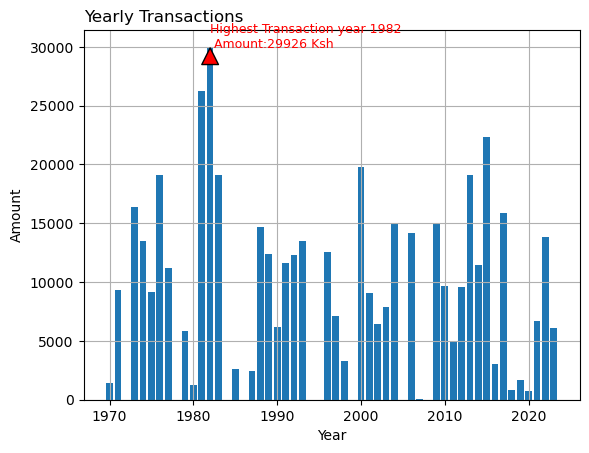

In [7]:
#Running the Pipeline manually.
#To produce data
Produce()
#To Extract/Consume the Data
df = Extract()
#To Transform the Data
grouped_df = Transform(df)
# To Visualize data
Visualize(grouped_df)
